# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> AC209B Advanced Topics in Data Science

## Final Project: Meow Meow -- Classification of Cat Sounds


**Harvard University**<br/>
**Spring 2024**<br/>
**Group Members**: Soline Boussard,  Niki Ekstrom, Michelle Hewson, Sydney Levy, Aida York

---

# Table of Contents
1. [Introduction](#introduction)
2. [Data Loading & Cleaning](#dataloading)
3. [Exploratory Data Analysis](#eda)
4. [Baseline CNN Model](#baseline)
5. [Tuned CNN Model](#models)
6. [Transfer Learning Model](#transfer)
7. [Model Performance](#performance)
8. [Real Data](#real)
9. [Future Work/Scope of Improvement](#future)

# Introduction <a name="introduction"></a>

## Motivation

Pets are known as a man’s best friend. 66% of U.S. households own a pet and yet many people have no way of understanding their pets emotions. Through our project, we will focus specifically on cats and understanding what their different meows mean. We will focus on ten different emotions a cat can display through their meows: angry, defense, fighting, happy, hunting mind, mating, mother call, paining, resting, and warning. 

We hope to create a model that generalizes to not only the cat meows in our training dataset but to all cats throughout the U.S. We will display how our model works on the meows of one of our own personal cats. This will allow pet owners across the country to better understand their cats and grow closer to each other. 


## Project Questions

How well can we classify the emotions of cat meows based on the 5,922 training audio files? Are there some emotions that are classified more accurately than others? What are the types of errors that the models make?

## Project Goal

The goal of this project is to see how well we can classify the emotions of cat meows based on the 5,922 training audio files. We want to achieve the highest accuracy possible and also understand which emotions are predicted most accurately.  
Through our EDA we found that we have relatively balanced class sizes which will allow us to use accuracy as our primary metric. We will look at both the overall accuracy of the model as well as the accuracy for each class (cat emotion). 


## Library Installations

In [1]:
!pip install librosa

Defaulting to user installation because normal site-packages is not writeable


In [2]:
#!pip install numpy scipy matplotlib librosa IPython
import numpy as np
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from tqdm import tqdm
from random import randint
from IPython.display import Image, Audio
from PIL import Image


2024-05-06 22:30:23.044231: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-06 22:30:23.089526: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-06 22:30:23.089566: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-06 22:30:23.090695: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-06 22:30:23.098039: I tensorflow/core/platform/cpu_feature_guar

## Library Dependencies

Many of the libraries we utilize in this project are common libraries that we have seen in class like numpy, pandas, matplotlib, sklearn, and tensorflow. One of the libraries that we depended on the most for our audio data is librosa. Librosa is a python package for music and audio analysis, which provides the necessary tools to extract audio features. We used this library to create mel spectrograms of the audio files so we could feed them into our CNN models to classify different cat meows based on their emotions. Mel spectrograms are visual representations of the spectrum of frequencies of an audio signal as it varies over time, aka a visual representation of the cat meows over time.

# Data Loading & Cleaning <a name="dataloading"></a>

## Data Description
Our data frame has 5,912 rows and 3 columns, one for the file path, one with a list of the audio data, and one for the emotion label. This means that we have 5,912 audio files of different cat noises and their labels. None of the columns have null values. Each entry in the list of the audio data represents the amplitude of the audio, so it does not make sense to create traditional descriptive statistics. 


We created additional features to better visualize the data using the librosa python package. This package allowed us to compute the mel spectrogram and its logarithmic transformation of each audio signal. The mel spectrogram represents the frequency of the audio over time and its logarithmic transformation allows us to better visualize the lower-intensity components of the audio. Thus, both of these features will be important for allowing us to classify the emotions of the different cat meow audio files. Finally, we normalize the log spectrogram to make sure that all audio files are all on the same scale.


## Reading in the audio files

In [3]:
#All audios are held in this directory with subfolders for each emotion
directory = "NAYA_DATA_AUG1X"

audio_data_list = []
file_paths_list = []
emotions_list = []

ms = []
log_ms = []

for root, dirs, files in os.walk(directory):
    for file in files:
        file_path = os.path.join(root, file)
        # Check if the file is an mp3 file
        if file_path.endswith(".mp3"):
            # Load audio data
            audio_data, sr = librosa.load(file_path)

            # Desired length is 5 seconds
            desired_length = int(5 * sr)  
            
            # Pad the signal to 5 seconds
            audio_padded = librosa.util.fix_length(audio_data, size=desired_length)

            # Create mel spectogram of audio, take log, and normalize
            mel_spec = librosa.feature.melspectrogram(y=audio_padded, sr=sr)

            log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

            normalized_log_mel_spec = (log_mel_spec - np.min(log_mel_spec)) / (np.max(log_mel_spec) - np.min(log_mel_spec))

            log_ms.append(normalized_log_mel_spec)
            ms.append(mel_spec)

            # Append audio data and file path to the respective lists
            audio_data_list.append(audio_padded)
            file_paths_list.append(file_path)
            
            # Extract emotion from the directory name
            emotion = os.path.basename(os.path.dirname(file_path))
            emotions_list.append(emotion)

Note: Illegal Audio-MPEG-Header 0xbf082800 at offset 7536.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


In [4]:
# Convert the data into a Pandas dataframe
data = {
    'File_Path': file_paths_list,
    'Audio_Data': audio_data_list,
    'Emotion': emotions_list
}

df = pd.DataFrame(data)
df.head()

,File_Path,Audio_Data,Emotion
0,NAYA_DATA_AUG1X/Fighting/car_extcoll0101.mp3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Fighting
1,NAYA_DATA_AUG1X/Fighting/cat0334.mp3,"[-2.3283064e-10, -1.1641532e-09, 0.0, -2.09547...",Fighting
2,NAYA_DATA_AUG1X/Fighting/YashLL_Cat0236Fit.mp3,"[2.0954758e-08, 3.3527613e-08, -7.450581e-09, ...",Fighting
3,NAYA_DATA_AUG1X/Fighting/YashLL_Cat0237Fit_aug...,"[-6.1647035e-05, -6.317347e-05, -8.239411e-05,...",Fighting
4,NAYA_DATA_AUG1X/Fighting/Last_addCat363Fit_aug...,"[0.0002870597, 0.00075750623, 0.0008200917, -3...",Fighting


In [5]:
df.shape

(5922, 3)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5922 entries, 0 to 5921
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   File_Path   5922 non-null   object
 1   Audio_Data  5922 non-null   object
 2   Emotion     5922 non-null   object
dtypes: object(3)
memory usage: 138.9+ KB


## Cleaning and Preprocessing the Data

### Missing Data: 
Some audio files are longer than others. For these cases, we padded the shorter audio files with 0. We did not shorten any audio files in case important sounds were recorded during the beginning or end of longer audio files. 

### Data Imbalance:
Our data is relatively balanced, with each emotion within 5% of the others:
- Mating: 602 sounds
- Warning: 600 sounds
- Angry: 600 sounds
- Fighting: 600 sounds
- Happy: 594 sounds
- Mother call: 592 sounds
- Resting: 592 sounds
- Paining: 582 sounds
- Defense: 582 sounds
- HuntingMind: 578 sounds

Therefore, we did not address data imbalance in this notebook.

In [7]:
# Counts of each emotion 
emotion_counts = df['Emotion'].value_counts()
print(emotion_counts)

Emotion
Mating         602
Fighting       600
Warning        600
Angry          600
Happy          594
Resting        592
MotherCall     592
Defence        582
Paining        582
HuntingMind    578
Name: count, dtype: int64


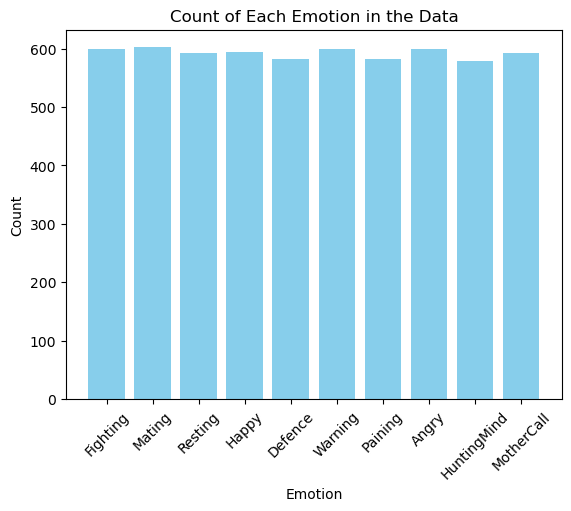

In [8]:
emotion_counts = df['Emotion'].value_counts(sort=False)
plt.bar(df['Emotion'].unique(), emotion_counts, color='skyblue')
plt.xticks(rotation=45)
plt.title("Count of Each Emotion in the Data")
plt.ylabel("Count")
plt.xlabel("Emotion")
plt.show()

As shown in the count bar plot, we can see that classes are fairly balanced. 

# Exploratory Data Analysis <a name="eda"></a>

## Data Visualization

First, we want to actually listen to what the data we are dealing with sounds like. Play the below audio to hear what a happy cat meow sounds like in this dataset.

In [9]:
mp3_file_path = "NAYA_DATA_AUG1X/Happy/1295_1256854283.mp3"
Audio(mp3_file_path)

We wanted to visualize a single audio waveform to understand what 1 row of our data represents visually. This is the audio visualization of the angry cat audio from above. Note the silence after 3 seconds because we padded the data so that all files are 5 seconds long.

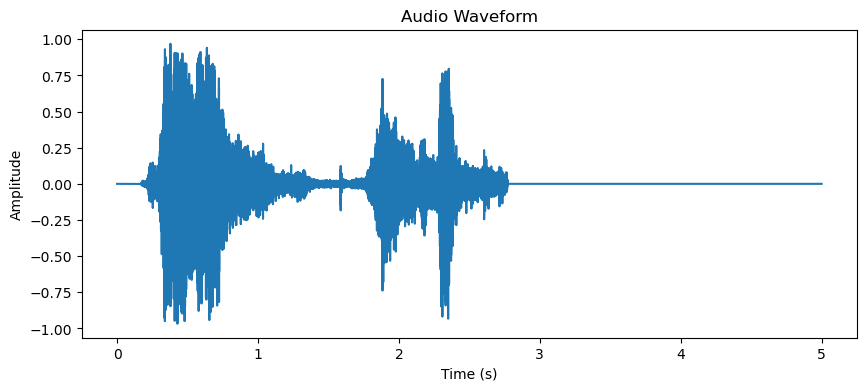

In [10]:
plt.figure(figsize=(10, 4))
plt.plot(np.arange(len(df.Audio_Data[0])) / sr, df.Audio_Data[0])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Audio Waveform')
plt.show()

Second, we wanted to visualize the audio waveforms for sample audios of each meow emotion. This allows us to compare the amplitude of the audio waveforms for each emotion over time. Observe that each emotion is characterized by distinct waveforms, highlighting the unique representation of each emotion. However, some emotions are very similar in this example. Notice that Mating and Happy both have similar shapes, while Defence and MotherCall do, too.

In [11]:
# Get one example meow from each emotion
def get_random_indices(df):
    random_indices = {}
    for emotion in df['Emotion'].unique():
        # Filter DataFrame by emotion
        emotion_df = df[df['Emotion'] == emotion]
        # Randomly select one index
        random_index = np.random.choice(emotion_df.index)
        random_indices[emotion] = random_index
    return random_indices

emotion_dict = get_random_indices(df)

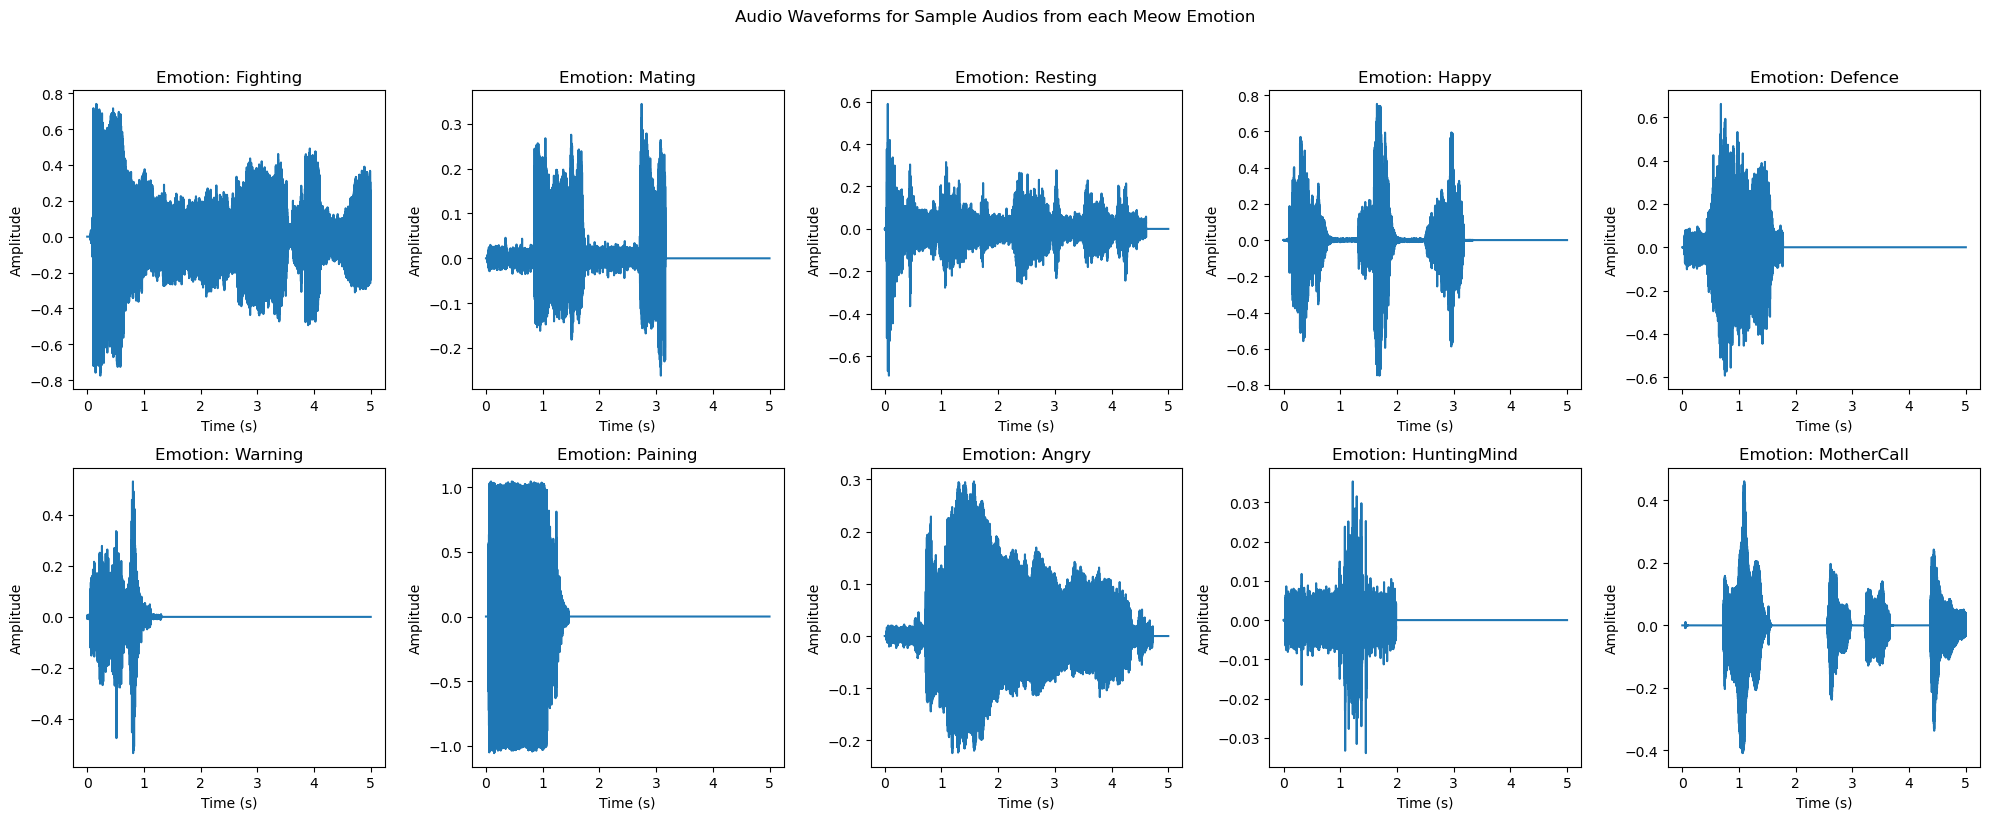

In [12]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for i, (emotion, index) in enumerate(emotion_dict.items()):
    audio_data = df.loc[index, 'Audio_Data']
    time_axis = np.arange(len(audio_data)) / sr
    axes[i].plot(time_axis, audio_data)
    axes[i].set_xlabel('Time (s)')
    axes[i].set_ylabel('Amplitude')
    axes[i].set_title(f'Emotion: {emotion}')

fig.suptitle("Audio Waveforms for Sample Audios from each Meow Emotion", y=1.02)  
plt.tight_layout()
plt.show()

Here, we visualize different mel spectrograms for each Meow emotion. A mel spectrogram is a representation of the short-term power spectrum of a sound, where the frequencies are converted into the mel scale. The values in the mel spectrogram represent the power (or magnitude) of each frequency bin over time. As you can see, the plots are not very descriptive.

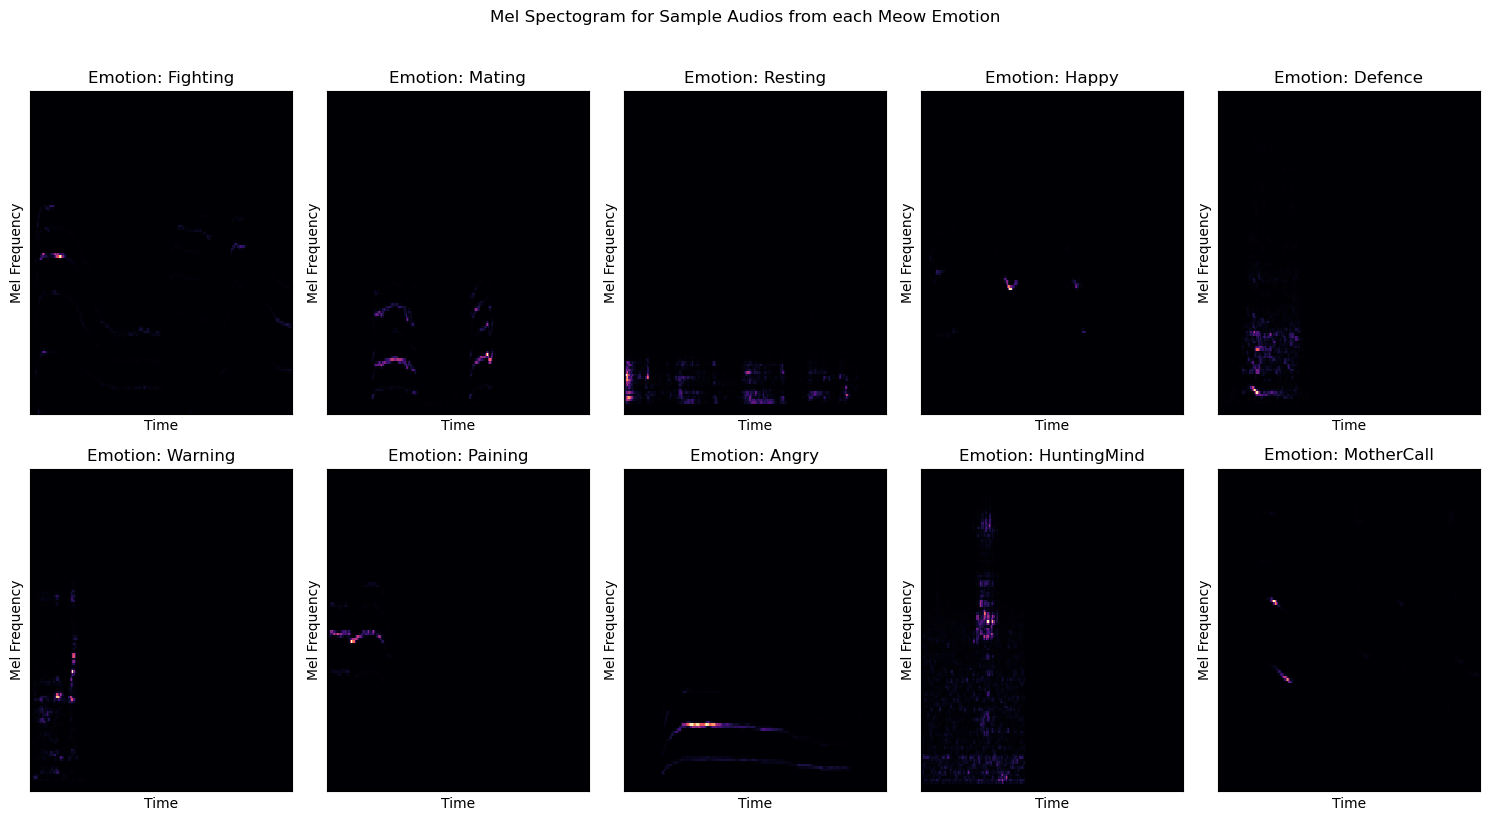

In [13]:
fig, axes = plt.subplots(2, 5, figsize=(15, 8))

axes = axes.flatten()

for i, (emotion, index) in enumerate(emotion_dict.items()):
    sample_log_ms = ms[index]
    librosa.display.specshow(sample_log_ms, sr=sr, ax=axes[i])
    axes[i].set_title(f"Emotion: {emotion}")
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Mel Frequency')

fig.suptitle("Mel Spectogram for Sample Audios from each Meow Emotion", y=1.02)
plt.tight_layout()
plt.show()

In the next visualization, we see the Log Mel Spectrogram for sample audios from each meow emotion. This results in a better visualization because human perception of loudness is approximately logarithmic, therefore we use a logarithmic transformation to the values of the mel spectrogram. In these visualizations, the mel spectrogram is converted to decibel (dB) units, which is on the logarithmic scale.
We picked a random index for each emotion in our dataset and visualized its log mel spectrogram, which captures how the frequency of the audio changes over time. A log mel spectrogram includes the vertical axis displaying frequency in Hertz, the horizontal axis representing time of the audio track, and amplitude being represented by brightness/color. The black background is silence and the bright curve is the sine wave moving up in pitch.

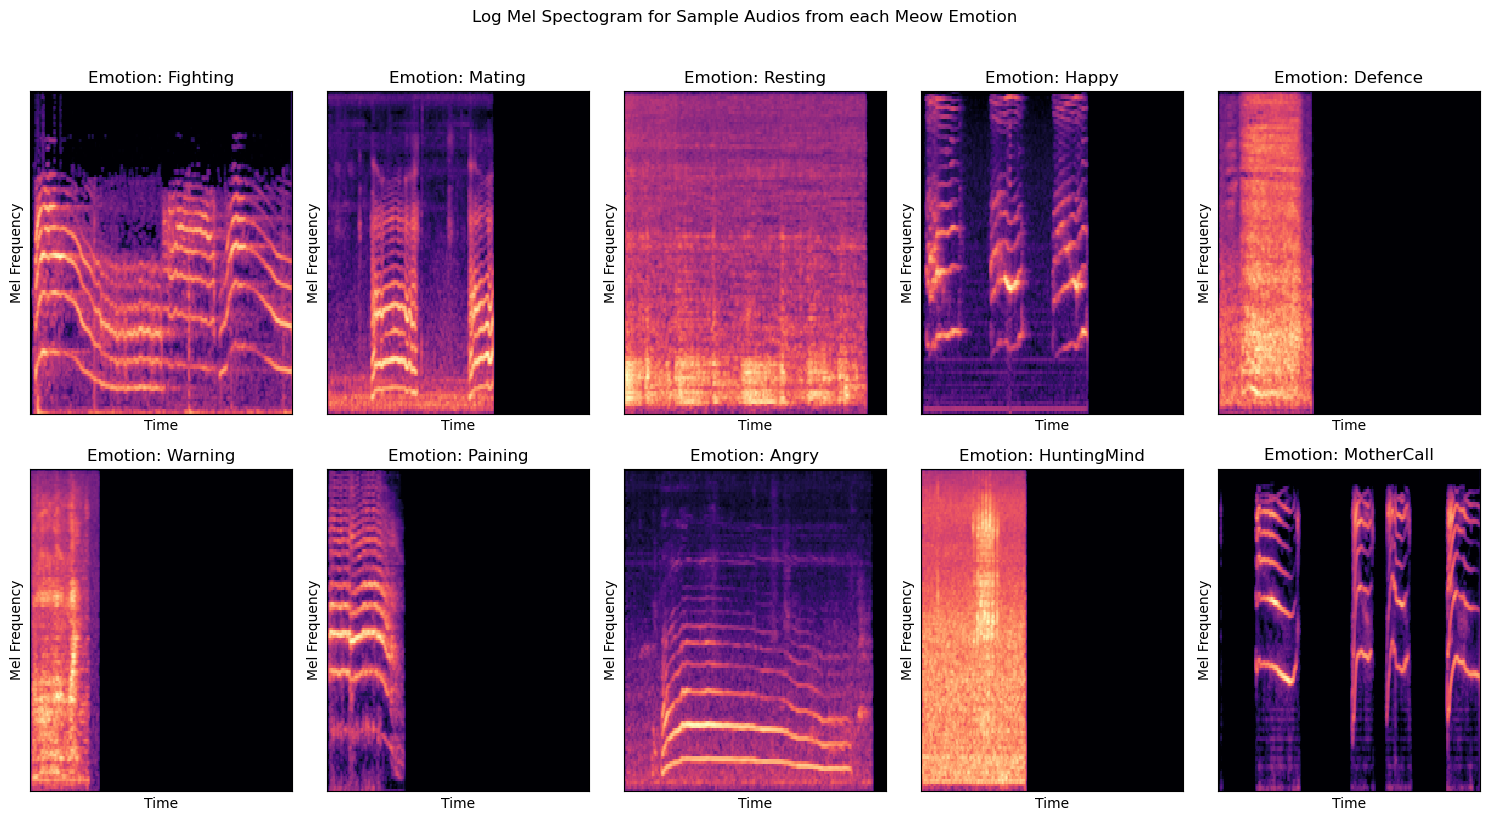

In [14]:
fig, axes = plt.subplots(2, 5, figsize=(15, 8))

axes = axes.flatten()

for i, (emotion, index) in enumerate(emotion_dict.items()):
    sample_log_ms = log_ms[index]
    librosa.display.specshow(sample_log_ms, sr=sr, ax=axes[i])
    axes[i].set_title(f"Emotion: {emotion}")
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Mel Frequency')

fig.suptitle("Log Mel Spectogram for Sample Audios from each Meow Emotion", y=1.02)
plt.tight_layout()
plt.show()

## Summary of Data Processing/EDA

Overall, we found that it was relatively difficult to perform EDA on audio data. Once we were able to convert the audio files to spectrograms we were able to actually visualize the data we will be training our future model with. The spectrograms provide a unique insight into the types of audio associated with the various cat emotions. Some emotions show clear lines in the log mel spectrograms, while others show a more uniform amplitude over the frequencies. When listening to the audios corresponding to the emotions, we found that those with clear spectrogram lines have more of a clear tone. We also found that all the audio files did not have the same lengths, thus we padded the audio files to all be five seconds long. We also one hot encoded the emotions to be more easily passed into the models. 

# Baseline CNN Model <a name="baseline"></a>

Given the large size of our dataset, we took advantage of the TensorFlow pipeline to convert our dataset into a TensorFlow dataset. This allows us to batch the data when feeding it into the model for better computational efficiency and memory management. 
For our baseline model, we ran a basic CNN on our dataset. We chose a CNN model for processing the audio images because CNNs can capture hierarchical patterns in spectral features. Our baseline model includes two convolutional layers, two pooling layers, a flattened layer, two dense layers with a final dense layer with a softmax activation. The convolutional layers have 32 filters, and 64 filters both with kernel size of 3x3. The maxpooling layers have window size of 2x2. The first dense layer has 128 units and the second dense has 10 units, one for each emotion. Following the compilation of our model, we ended up with  13,479,690 parameters. We ran the model for 15 epochs to get a baseline understanding of how the model is performing with our data. We used an adam optimizer, categorical crossentropy loss, and accuracy as our primary metric. To evaluate the model, we used accuracy as our metric, as our dataset is pretty balanced between the emotions. 

 


## Build dataset for model and split into train/test

In [15]:
# Encode the labels using one-hot-encoding
label_encoder = LabelEncoder()
emotions_encoded = label_encoder.fit_transform(emotions_list)
emotions_onehot = to_categorical(emotions_encoded)

# create tensorflow datasets from spectrograms and labels
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices((log_ms, emotions_onehot))
dataset = dataset.shuffle(10000) 
dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

2024-05-06 22:32:52.513904: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-06 22:32:52.523096: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-06 22:32:52.526005: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [16]:
#train test split with 15% test size
X_train_val, X_test, y_train_val, y_test = train_test_split(
    log_ms, emotions_onehot, test_size=0.15, random_state=42)

# split the training set further into training and validation sets with 15% validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.15, random_state=42) 

In [17]:
# Convert training data into a TensorFlow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Convert validation data into a TensorFlow dataset
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Convert test data into a TensorFlow dataset
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

## Check that the training, validation and test datasets are balanced

In [18]:
def check_class_distribution(dataset, label_encoder):
    all_labels = np.concatenate([y.numpy() for x, y in dataset], axis=0)
    decoded_labels = label_encoder.inverse_transform([np.argmax(label) for label in all_labels])
    class_counts = np.unique(decoded_labels, return_counts=True)
    return dict(zip(class_counts[0], class_counts[1]))

train_distribution = check_class_distribution(train_dataset, label_encoder)
val_distribution = check_class_distribution(val_dataset, label_encoder)
test_distribution = check_class_distribution(test_dataset, label_encoder)

print("Training set distribution:", train_distribution)
print("Validation set distribution:", val_distribution)
print("Test set distribution:", test_distribution)

Training set distribution: {'Angry': 423, 'Defence': 412, 'Fighting': 420, 'Happy': 431, 'HuntingMind': 438, 'Mating': 448, 'MotherCall': 420, 'Paining': 419, 'Resting': 424, 'Warning': 443}
Validation set distribution: {'Angry': 86, 'Defence': 74, 'Fighting': 72, 'Happy': 75, 'HuntingMind': 70, 'Mating': 72, 'MotherCall': 82, 'Paining': 80, 'Resting': 78, 'Warning': 66}
Test set distribution: {'Angry': 91, 'Defence': 96, 'Fighting': 108, 'Happy': 88, 'HuntingMind': 70, 'Mating': 82, 'MotherCall': 90, 'Paining': 83, 'Resting': 90, 'Warning': 91}


## Baseline CNN Model Flowchart

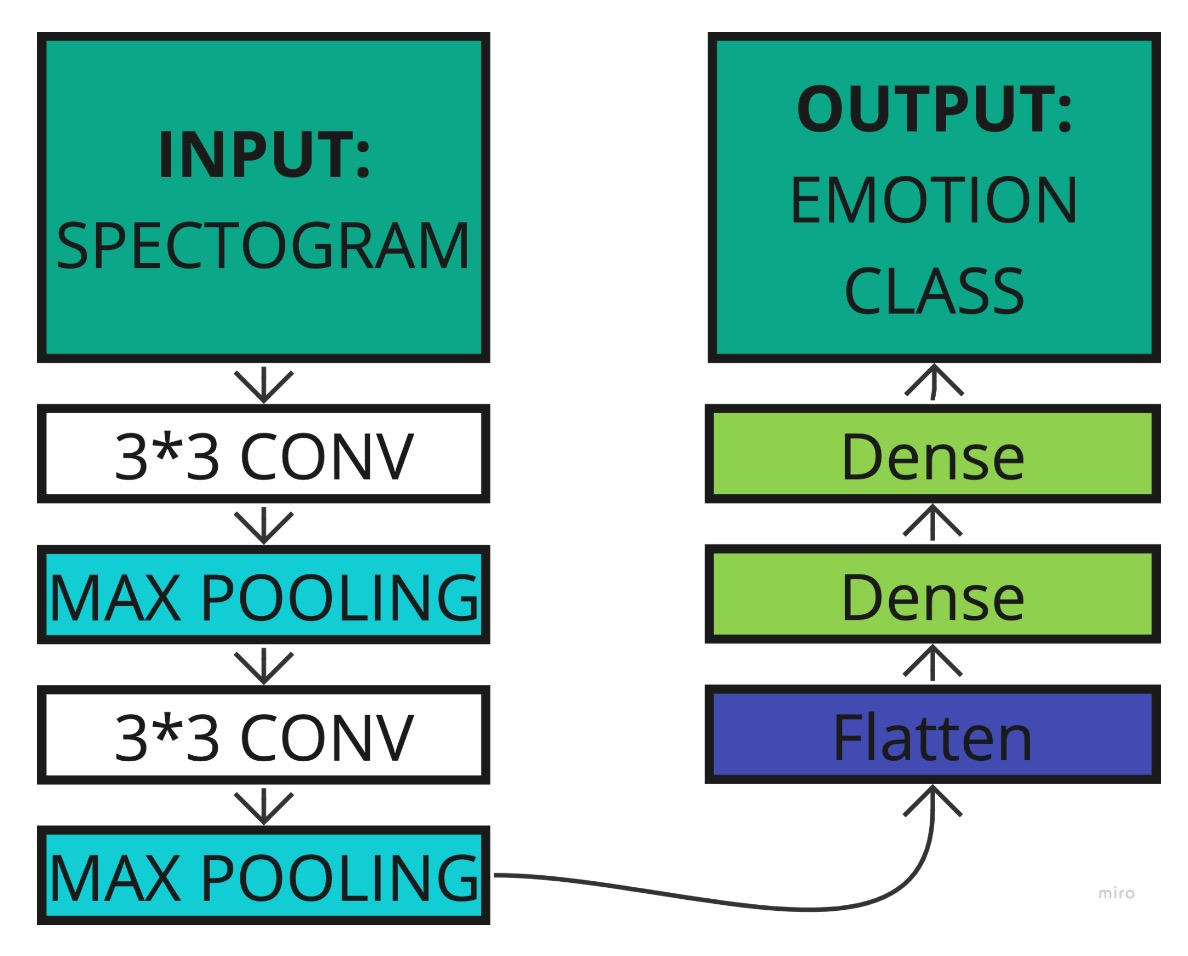

In [19]:
import IPython
IPython.display.Image("baseline.png")

The above is a flow chart representing the structure of our Baseline CNN model. 

## Build baseline model

In [20]:
baseline_model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, log_ms[0].shape[1], 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    
    # Flattening the 3D outputs to 1D and adding Dense layers
    Flatten(),
    Dense(128, activation='relu'),
    
    # Output layer
    Dense(emotions_onehot.shape[1], activation='softmax')
])

baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 214, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 107, 32)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 63, 107, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 31, 53, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 105152)            0         
                                                                 
 dense (Dense)               (None, 128)               1

In [21]:
baseline_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [22]:
time_start = time.time()
epochs = 15

history = baseline_model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset
)
time_end = time.time()
print(f"It took {(time_end - time_start)/60:.2f} minutes for the training to train")

Epoch 1/15


2024-05-06 22:33:22.127808: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2024-05-06 22:33:22.255205: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-06 22:33:22.695729: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-06 22:33:22.776519: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f4998fc48c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-06 22:33:22.776557: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-05-06 22:33:22.782503: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1715034802.889874    2152 device_compiler.h:186] Compiled

134/134 [==============================] - 7s 29ms/step - loss: 1.5005 - accuracy: 0.4776 - val_loss: 1.0654 - val_accuracy: 0.6517
Epoch 2/15
134/134 [==============================] - 3s 22ms/step - loss: 0.8469 - accuracy: 0.7101 - val_loss: 0.9211 - val_accuracy: 0.7152
Epoch 3/15
134/134 [==============================] - 3s 22ms/step - loss: 0.5131 - accuracy: 0.8338 - val_loss: 0.7569 - val_accuracy: 0.7589
Epoch 4/15
134/134 [==============================] - 3s 22ms/step - loss: 0.2719 - accuracy: 0.9170 - val_loss: 0.7214 - val_accuracy: 0.7974
Epoch 5/15
134/134 [==============================] - 3s 22ms/step - loss: 0.1348 - accuracy: 0.9619 - val_loss: 0.7269 - val_accuracy: 0.8185
Epoch 6/15
134/134 [==============================] - 3s 22ms/step - loss: 0.0595 - accuracy: 0.9867 - val_loss: 0.7311 - val_accuracy: 0.8344
Epoch 7/15
134/134 [==============================] - 3s 22ms/step - loss: 0.0260 - accuracy: 0.9963 - val_loss: 0.7899 - val_accuracy: 0.8411
Epoch 8/15

In [23]:
test_loss, test_accuracy = baseline_model.evaluate(test_dataset)
print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")

28/28 [==============================] - 0s 13ms/step - loss: 1.0803 - accuracy: 0.7987
Test loss: 1.0803254842758179, Test accuracy: 0.7986501455307007


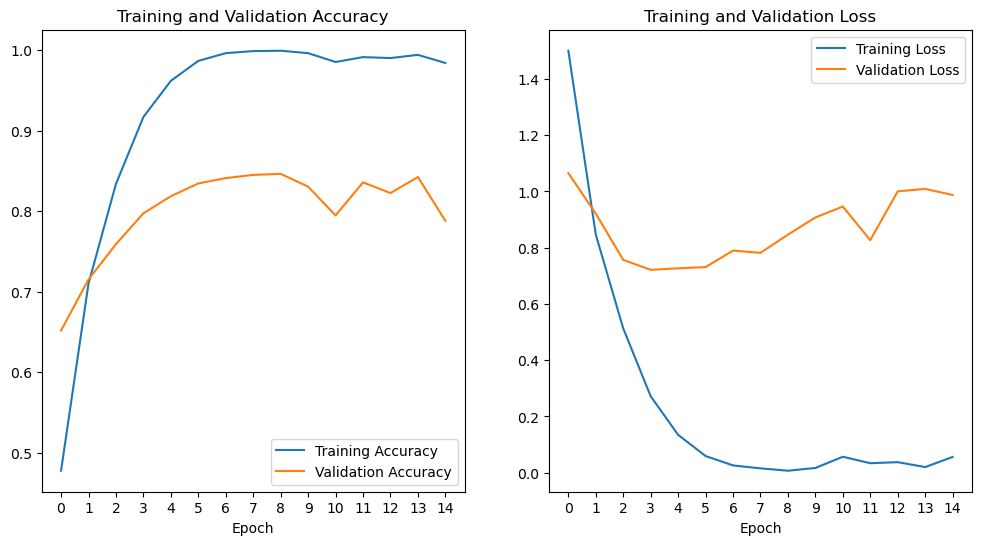

In [24]:
# Plot training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['accuracy']))  
plt.figure(figsize=(12, 6))

# Subplot for accuracy
plt.subplot(1, 2, 1)  
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')
plt.xticks(epochs_range)
plt.xlabel('Epoch')

# Subplot for loss
plt.subplot(1, 2, 2) 
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')
plt.xticks(epochs_range)
plt.xlabel('Epoch');

Based on the training history of the model, we see severe overfitting with the training accuracy much higher than the validation accuracy and the training loss much lower than the validation loss. In our tuned model we address these issues. 

In [25]:
# get accuracy for each class label
label_accuracies = {}

for features, label in test_dataset:
    predictions = baseline_model.predict(features, verbose=0)
    predicted_label = tf.argmax(predictions, axis=1).numpy()
    true_label = np.argmax(label, axis=1)
    true_label_names = label_encoder.inverse_transform(true_label)
    
    for i in range(len(true_label)):
        if true_label_names[i] not in label_accuracies:
            label_accuracies[true_label_names[i]] = {"count": 0, "accuracy": 0.0}
        label_accuracies[true_label_names[i]]["count"] += 1
        label_accuracies[true_label_names[i]]["accuracy"] += int(true_label[i] == predicted_label[i])

for label, values in label_accuracies.items():
    values["accuracy"] /= values["count"]
    print(f"{label} Accuracy:{values['accuracy']:.2f} (count = {values['count']})")


Happy Accuracy:0.69 (count = 88)
Resting Accuracy:0.89 (count = 90)
Paining Accuracy:0.78 (count = 83)
Angry Accuracy:0.89 (count = 91)
Warning Accuracy:0.68 (count = 91)
HuntingMind Accuracy:0.67 (count = 70)
Defence Accuracy:0.96 (count = 96)
Fighting Accuracy:0.74 (count = 108)
Mating Accuracy:0.80 (count = 82)
MotherCall Accuracy:0.84 (count = 90)


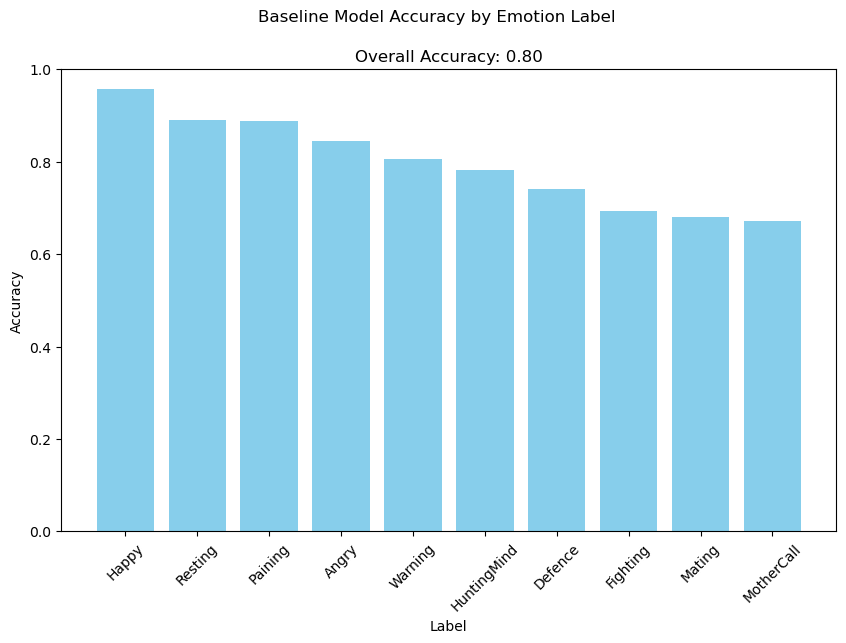

In [26]:
labels = [label for label in label_accuracies]
accuracies = [values['accuracy'] for values in label_accuracies.values()]
accuracies_sorted = sorted(accuracies, reverse=True)

plt.figure(figsize=(10, 6))
plt.bar(labels, accuracies_sorted, color='skyblue')
plt.xlabel('Label')
plt.ylabel('Accuracy')
plt.suptitle('Baseline Model Accuracy by Emotion Label')
plt.title(f"Overall Accuracy: {test_accuracy:.2f}")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()

Based on the plot above, happy achieves the highest accuracy while MotherCall has the lowest. Overall, there is not a huge discrepancy between the accuracy that each class label achieves.  

28/28 [==============================] - 0s 7ms/step


Text(0.5, 1.0, 'Confusion Matrix for Baseline Model')

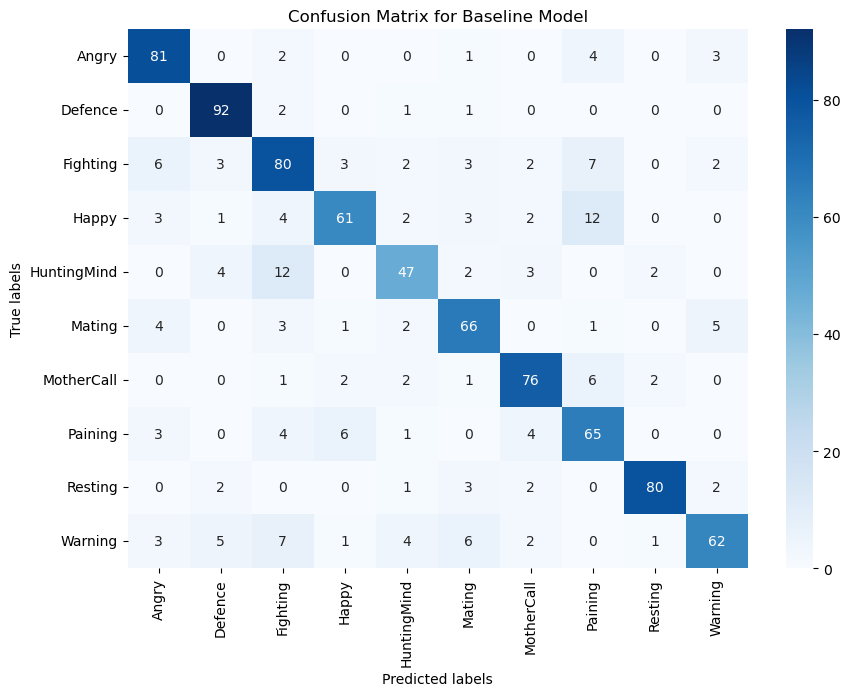

In [27]:
# Get confusion matrix
y_pred_probs = baseline_model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Baseline Model')

The above plot is a confusion matrix that allows us to better understand the types of errors that our model is making. The darker colors along the diagonals represent that most of the time our model is making accurate predictions. The most commonly confused labels for this model are: happy / paining and hunting mind / fighting. 

## Analyze baseline model

- The model’s validation loss after 15 epochs is 1.08 and the model’s validation accuracy was 0.788. The test accuracy was 0.799. The validation and test accuracy are a lot lower than the training accuracy (0.788 and 0.799 compared to 0.984), suggesting that there is overfitting. 

- A strength of the model is that it was able to achieve 78.8% validation accuracy and 79.9% test accuracy in only 15 epochs. This suggests that with additional training time we could achieve even higher accuracy without having to complicate the model. 
- One potential weakness of the model is its complexity, with over 13.5 million parameters which means that it is computationally intensive and requires a lot of memory.  
- For the tuned model, we early stopping and dropout to address the overfitting. We also add more layers to allow the model to learn more complex features.

1/1 [==============================] - 0s 23ms/step


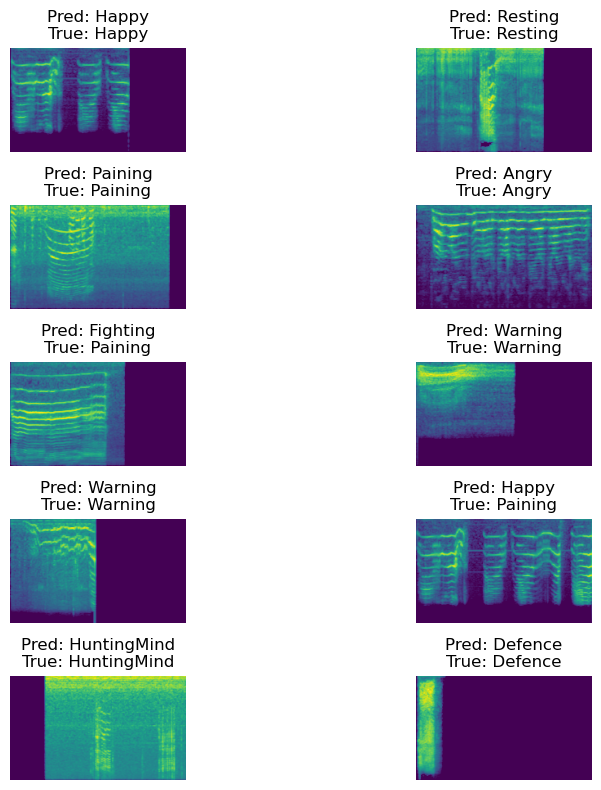

In [28]:
# Plot the spectograms with true and predicted labels 
for test_images, test_labels in test_dataset.take(1):  
    predictions = baseline_model.predict(test_images)  
    predicted_classes = np.argmax(predictions, axis=1)  
    true_classes = np.argmax(test_labels, axis=1)  

    # Get the true and predicted labels
    predicted_labels = label_encoder.inverse_transform(predicted_classes)
    true_labels = label_encoder.inverse_transform(true_classes)

    fig, axes = plt.subplots(5, 2, figsize=(10, 8))
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        non_padded_mask = np.any(test_images[i].numpy() != 0, axis=0)
        ax.imshow(test_images[i].numpy().squeeze())
        ax.set_title(f"Pred: {predicted_labels[i]}\nTrue: {true_labels[i]}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

    break

The above plot displays ten random spectrograms along with their true and predicted labels. The baseline model outputs the correct label for 8/10. We see that the incorrect labels follow the labels that were frequently confused for each other based on the confusion matrix above. One note is that the audio files for the spectrogram misclassified as Happy (instead of Paining) seems to be the an extended version of the same audio file as the one correctly predicted as happy. This presents a limitation in the dataset we were provided. 

## Understanding baseline model through feature maps

1/1 [==============================] - 0s 111ms/step


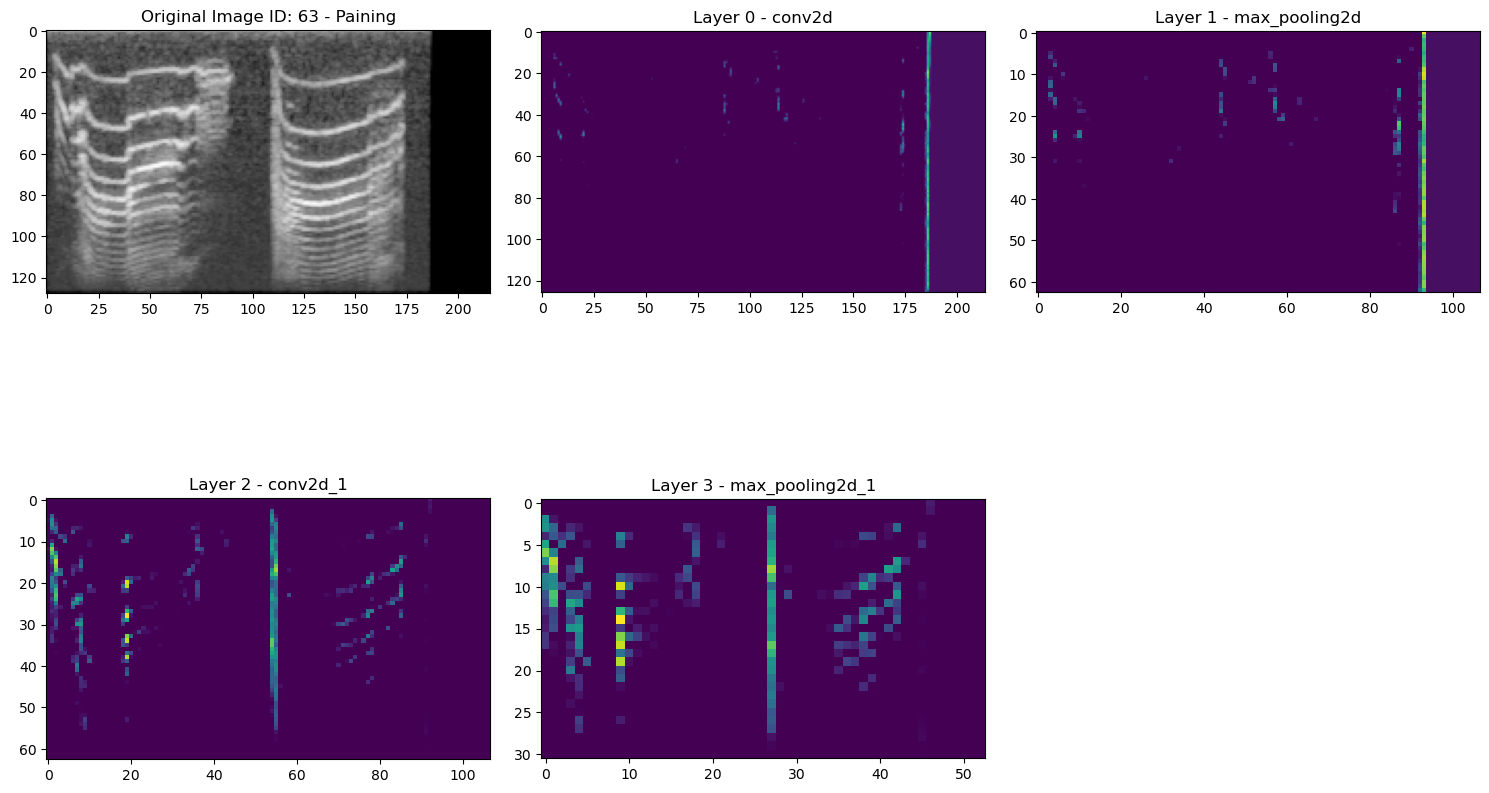

In [29]:
# Plot feature maps for each layer in baseline model
def get_feature_maps(model, layer_id, input_image):
    model_ = Model(inputs=[model.input], 
                   outputs=[model.layers[layer_id].output])
    return model_.predict(np.expand_dims(input_image, axis=0))[0,:,:,:].transpose((2,0,1))

def plot_features_map(img_idx=None, layer_idx=range(4), 
                      x_test=X_test, ytest=y_test, model=baseline_model):
    if img_idx is None:
        img_idx = randint(0, ytest.shape[0])
    input_image = X_test[img_idx]
    fig, ax = plt.subplots(2, 3, figsize=(15, 10))  
    ax[0][0].imshow(input_image.squeeze(), cmap='gray') 
    ax[0][0].set_title('Original Image ID: {} - {}'.format(img_idx, labels[np.argmax(ytest[img_idx])]))
    for i, l in enumerate(layer_idx):
        feature_map = get_feature_maps(baseline_model, l, input_image)
        ax[(i+1)//3][(i+1)%3].imshow(feature_map[0], cmap='viridis')
        ax[(i+1)//3][(i+1)%3].set_title('Layer {} - {}'.format(l, baseline_model.layers[l].name))
    fig.delaxes(ax[1, 2])
    plt.tight_layout()
    plt.show()

labels = ['Angry', 'Defence', 'Fighting', 'Happy', 'HuntingMind', 'Mating', 'MotherCall', 'Paining', 'Resting', 'Warning']

plot_features_map()


The above plot is a feature map for the baseline CNN model. We can see that layers 2 and 3 are capturing the horizontal lines that seem to be the distinguishing features of this audio file. 

# Tuned CNN Model <a name="models"></a>

After training the baseline model, we saw that is was severely overfitting to the training data. Thus, we wanted to make sure that when we tuned our new convolutional neural network, we did not have the same problem. We also wanted to make sure that this tuned model was deep enough to capture the complexities in the log mel spectrogram in order to accurately predict the emotion of the cat meow. In order to do this, we added added two additional convolutional layers and two additional max pooling layers. To avoid overfitting, we also added Dropout to the first dense layer. Our convolutional layers had 32, 64, 128, 256 filters respectively all with a kernel size of 3x3. Each max pooling layer had a window size of 2x2. The first dense layer has 128 units with a dropout rate of 0.5. Like the baseline model, the final dense layer has a total of 10 units with one for each class label. 

We experimented with data augmentation such as noise injection, pitch shifting and time stretching, but found that these methods not only decreased the training accuracy, but also the validation accuracy. Therefore, we decided to not do any data augmentation. This could be due to the fact that half of the audio data is already augmented.

After compiling the model, there were a total of 3,371,146 parameters. We used an adam optimizer, categorical crossentropy loss, and accuracy as our primary metric. 

We trained this model for 30 epochs, but added early stopping (with a patience of 5) to also counteract overfitting. We found that this new model not only performed better in terms of accuracy, but it also avoided overfitting compared to the baseline model. 


## Tuned CNN Model Flowchart

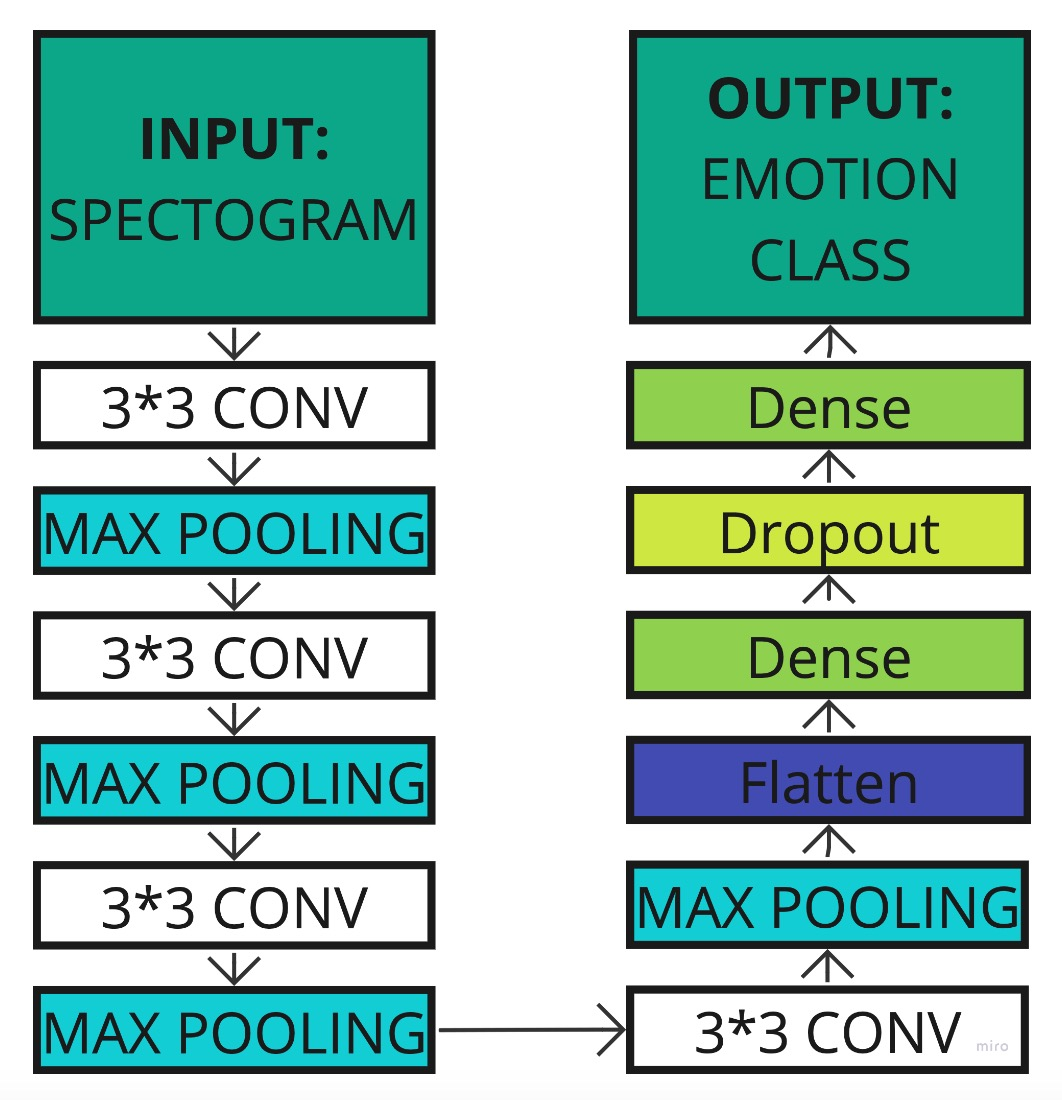

In [30]:
IPython.display.Image("tuned.png")

The above plot represents the flow chart for our tuned CNN model. Relative to the baseline model, this model has 2 additional convolutional and max pooling layers. We also add dropout to the first dense layer and employ early stopping when training this model, which we did not do in the baseline CNN model. 

In [31]:
# Create tuned version of baseline CNN 
tuned_model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, log_ms[0].shape[1], 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    
    # Flattening the 3D outputs to 1D and adding Dense layers
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    
    # Output layer
    Dense(emotions_onehot.shape[1], activation='softmax')
])

tuned_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 126, 214, 32)      320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 63, 107, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 63, 107, 64)       18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 31, 53, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 31, 53, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 15, 26, 128)      

In [32]:
tuned_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [33]:
epochs = 30
time_start = time.time()

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  
    restore_best_weights=True
)

tuned_history = tuned_model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=[early_stopping] 
)
time_end = time.time()
print(f"It took {(time_end - time_start)/60:.2f} minutes for the tuned model to train")

Epoch 1/30
134/134 [==============================] - 8s 33ms/step - loss: 1.9414 - accuracy: 0.2915 - val_loss: 1.2579 - val_accuracy: 0.5682
Epoch 2/30
134/134 [==============================] - 4s 27ms/step - loss: 1.3111 - accuracy: 0.5479 - val_loss: 0.9905 - val_accuracy: 0.6874
Epoch 3/30
134/134 [==============================] - 4s 27ms/step - loss: 1.0469 - accuracy: 0.6367 - val_loss: 0.8035 - val_accuracy: 0.7325
Epoch 4/30
134/134 [==============================] - 4s 27ms/step - loss: 0.8505 - accuracy: 0.7066 - val_loss: 0.6693 - val_accuracy: 0.7669
Epoch 5/30
134/134 [==============================] - 4s 27ms/step - loss: 0.6867 - accuracy: 0.7571 - val_loss: 0.7063 - val_accuracy: 0.7801
Epoch 6/30
134/134 [==============================] - 4s 27ms/step - loss: 0.6054 - accuracy: 0.7847 - val_loss: 0.5869 - val_accuracy: 0.8146
Epoch 7/30
134/134 [==============================] - 4s 27ms/step - loss: 0.4995 - accuracy: 0.8111 - val_loss: 0.5243 - val_accuracy: 0.8543

In [34]:
test_loss, test_accuracy = tuned_model.evaluate(test_dataset)
print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")

28/28 [==============================] - 0s 14ms/step - loss: 0.5015 - accuracy: 0.8650
Test loss: 0.5015267729759216, Test accuracy: 0.8650168776512146


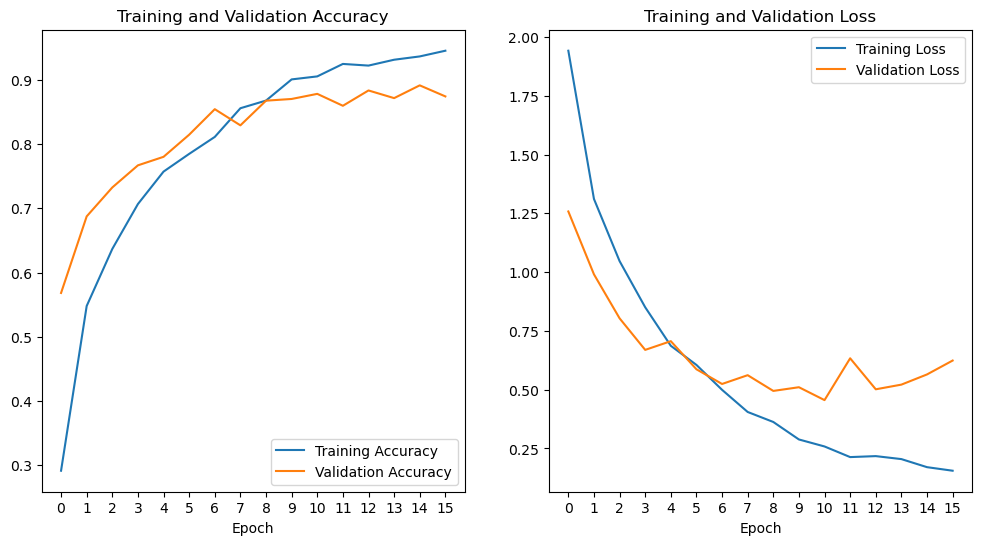

In [35]:
acc = tuned_history.history['accuracy']
val_acc = tuned_history.history['val_accuracy']
loss = tuned_history.history['loss']
val_loss = tuned_history.history['val_loss']

epochs_range = range(len(tuned_history.history['accuracy'])) 
plt.figure(figsize=(12, 6))

# Subplot for accuracy
plt.subplot(1, 2, 1)  
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')
plt.xticks(epochs_range)
plt.xlabel('Epoch')

# Subplot for loss
plt.subplot(1, 2, 2) 
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')
plt.xticks(epochs_range)
plt.xlabel('Epoch');

The training history for the tuned CNN model suggests that we have much less overfitting compared to the baseline CNN model. This model stopped training after 16 epochs based on the early stopping with a patience of 5. 

In [36]:
label_accuracies_tuned = {}

for features, label in test_dataset:
    predictions = tuned_model.predict(features, verbose=0)
    predicted_label = tf.argmax(predictions, axis=1).numpy()
    true_label = np.argmax(label, axis=1)
    true_label_names = label_encoder.inverse_transform(true_label)
    
    for i in range(len(true_label)):
        if true_label_names[i] not in label_accuracies_tuned:
            label_accuracies_tuned[true_label_names[i]] = {"count": 0, "accuracy": 0.0}
        label_accuracies_tuned[true_label_names[i]]["count"] += 1
        label_accuracies_tuned[true_label_names[i]]["accuracy"] += int(true_label[i] == predicted_label[i])

for label, values in label_accuracies_tuned.items():
    values["accuracy"] /= values["count"]
    print(f"{label} Accuracy:{values['accuracy']:.2f} (count = {values['count']})")


Happy Accuracy:0.86 (count = 88)
Resting Accuracy:0.92 (count = 90)
Paining Accuracy:0.72 (count = 83)
Angry Accuracy:0.92 (count = 91)
Warning Accuracy:0.74 (count = 91)
HuntingMind Accuracy:0.93 (count = 70)
Defence Accuracy:0.93 (count = 96)
Fighting Accuracy:0.92 (count = 108)
Mating Accuracy:0.74 (count = 82)
MotherCall Accuracy:0.94 (count = 90)


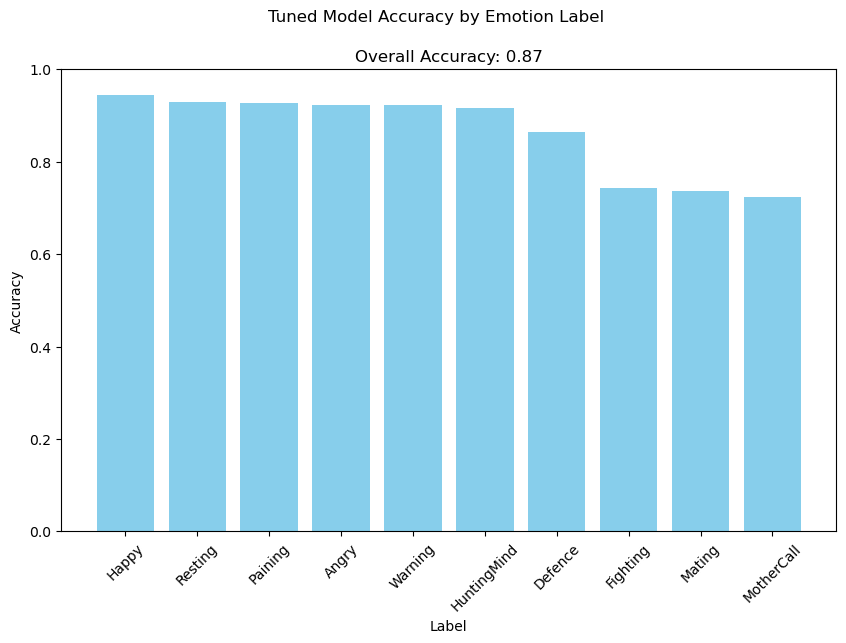

In [37]:
labels = [label for label in label_accuracies_tuned]
accuracies = [values['accuracy'] for values in label_accuracies_tuned.values()]
accuracies_sorted = sorted(accuracies, reverse=True)

plt.figure(figsize=(10, 6))
plt.bar(labels, accuracies_sorted, color='skyblue')
plt.xlabel('Label')
plt.ylabel('Accuracy')
plt.suptitle('Tuned Model Accuracy by Emotion Label')
plt.title(f"Overall Accuracy: {test_accuracy:.2f}")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()

Happy achieved the highest accuracy while MotherCall had the lowest. This is the same result we had in the baseline model. We can also see that the top 6 most accurate emotions all have very similar accuracies of approximately 0.93. 

28/28 [==============================] - 0s 10ms/step


Text(0.5, 1.0, 'Confusion Matrix for Tuned Model')

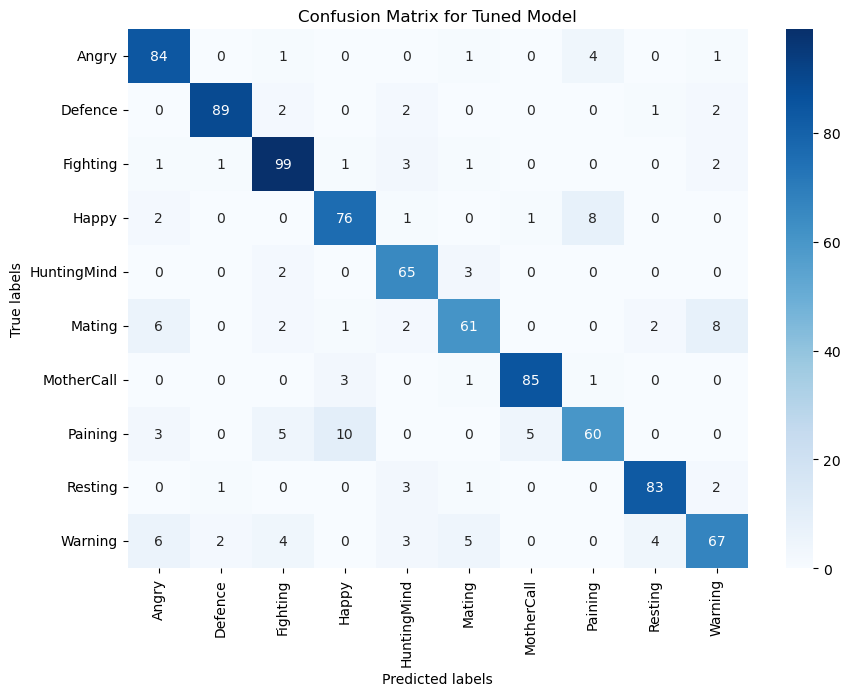

In [38]:
y_pred_probs = tuned_model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Tuned Model')

The above plot is a confusion matrix that allows us to better understand the types of errors that our tuned CNN model is making. The darker colors along the diagonals represent that most of the time our model is making accurate predictions. The most commonly confused labels for this model are: happy / paining and warning / mating. 

1/1 [==============================] - 0s 130ms/step


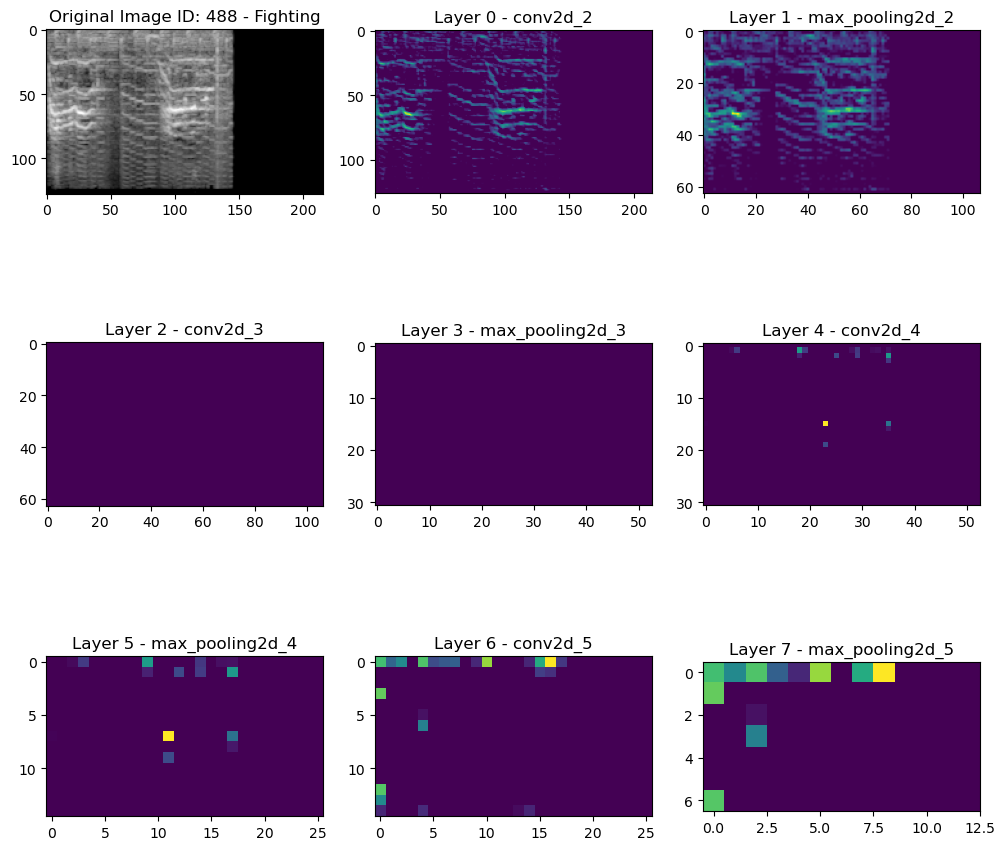

In [39]:
def plot_features_map(img_idx=None, layer_idx=range(8), 
                      x_test=X_test, ytest=y_test, model=tuned_model):
    if img_idx is None:
        img_idx = randint(0, ytest.shape[0])
    input_image = X_test[img_idx]
    fig, ax = plt.subplots(3, 3, figsize=(10, 10))
    ax[0][0].imshow(input_image.squeeze(), cmap='gray')  # Assuming input is grayscale
    ax[0][0].set_title('Original Image ID: {} - {}'.format(img_idx, labels[np.argmax(ytest[img_idx])]))
    for i, l in enumerate(layer_idx):
        feature_map = get_feature_maps(model, l, input_image)
        ax[(i+1)//3][(i+1)%3].imshow(feature_map[0], cmap='viridis')
        ax[(i+1)//3][(i+1)%3].set_title('Layer {} - {}'.format(l, model.layers[l].name))
    plt.tight_layout()
    plt.show()
labels =  ['Angry','Defence','Fighting','Happy','HuntingMind','Mating','MotherCall','Paining','Resting','Warning']

plot_features_map()

The above plot represents the feature maps for the layers in our tuned CNN model. Layers 0 and 1 are capturing the horizontal lines in the audio file. Layers 2 and 3 do not seem to be learning any specific feature from the initial image. The later layers are harder to interpret but the presence of brighter colors in the feature maps suggest they are still being used in order to predict the final meow emotion. 

## Analyze Tuned Model

- The model’s validation loss after 15 epochs is 0.565 and the model’s validation accuracy was 0.891. The test accuracy was 0.865. The validation and test accuracy are lower than the training accuracy (0.891 and 0.865 compared to 0.936), suggesting that there is overfitting. 
- A strength of the model is that it was able to achieve 89.1% validation accuracy and 86.5% test accuracy, which is a lot higher than the baseline model. The accuracy plot shows that the validation accuracy barely improved after 8 epochs, suggesting that the model was unable to learn much after that. 
- Another strength of this model is that it has much fewer trainable parameters compared to the dense model (3.4 million compared to 13.5 million), which is due to the fact that the convolutional and max pooling layers reduce the size of the images before the Flatten() layer.

# Transfer Learning Model - MobileNet <a name="transfer"></a>

Finally, we decided to do transfer learning with MobileNet to see if a model with pre-trained weights on a larger image dataset could increase the overall performance of our model. In order to use MobileNet, all images had to first be rescaled to size (224,224,3). We experimented with unfreezing some layers (between 2 and 20 layers) of MobileNet in addition to the output layer, but found that this decreased the performance. We also tested adding different numbers of layers on top of the last MobileNet layer and different learning rates, until we settled for a simple model with one global average pooling layer, one dense layer, and an output layer with a softmax activation function. We also found that using a learning rate of 3e-5 led to the best performance. 

We trained this model for 20 epochs, but added early stopping (with a patience of 2) to also counteract overfitting. We found that this new model performed better than the baseline model but worse than the tuned CNN model. The number of trainable parameters is 1,321,994. 

## MobileNet Flowchart 

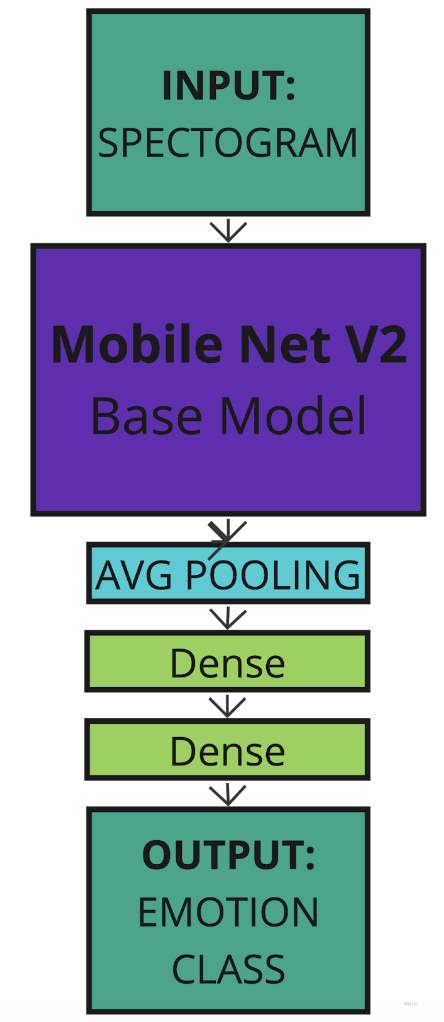

In [40]:
IPython.display.Image("Mobile.png")

The above plot shows the flow chart of our transfer learning model. We used MobileNet as our base model with all model weights frozen. We removed the final dense layer from MobileNet as our problem requires a different output layer with a different number of units. On top of the MobileNet model we added an average pooling layer, a dense layer and a dense output layer with a softmax activation function.

In [41]:
# Base directory for data
base_dir = "NAYA_DATA_AUG1X"

# Output directories
output_base = "processed_data_mobilenet"
train_dir = os.path.join(output_base, 'train')
val_dir = os.path.join(output_base, 'validation')
test_dir = os.path.join(output_base, 'test')
emotions_list_mobile = sorted(os.listdir(train_dir))

# Create directories only if they do not contain files
for dir in [train_dir, val_dir, test_dir]:
    os.makedirs(dir, exist_ok=True)


# Gather all audio files
data = []
for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.endswith(".mp3"):
            path = os.path.join(root, file)
            emotion = os.path.basename(root)
            data.append((path, emotion))

# Process spectrograms and save as png 
def process_and_save(files, output_dir):
    for file_path, emotion in tqdm(files):
        audio_data, sr = librosa.load(file_path, sr=None, mono=True)

        mel_spec = librosa.feature.melspectrogram(y=audio_data, sr=sr)
        log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
        normalized_log_mel_spec = (log_mel_spec - np.min(log_mel_spec)) / (np.max(log_mel_spec) - np.min(log_mel_spec))

        image = Image.fromarray(np.uint8(normalized_log_mel_spec * 255))
        resized_image = image.resize((224, 224))

        class_dir = os.path.join(output_dir, emotion)
        os.makedirs(class_dir, exist_ok=True)
        image_file_name = os.path.basename(file_path).replace('.mp3', '.png')
        resized_image.save(os.path.join(class_dir, image_file_name))


# Check if directories are empty and process files accordingly
if not os.listdir(train_dir):
    train_files, test_files = train_test_split(data, test_size=0.30, stratify=[d[1] for d in data])
    val_files, test_files = train_test_split(test_files, test_size=0.5, stratify=[d[1] for d in test_files])
    process_and_save(train_files, train_dir)
    process_and_save(val_files, val_dir)
    process_and_save(test_files, test_dir)

In [42]:
# Generate train, test, and validation sets 
train_datagen = ImageDataGenerator(rescale=1./255,)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 4147 images belonging to 10 classes.
Found 888 images belonging to 10 classes.
Found 889 images belonging to 10 classes.


In [43]:
# Get the class indices for each generator
train_class_indices = train_generator.class_indices
val_class_indices = validation_generator.class_indices
test_class_indices = test_generator.class_indices

# Invert the dictionary to map indices to class names
train_idx_to_class = {v: k for k, v in train_class_indices.items()}
val_idx_to_class = {v: k for k, v in val_class_indices.items()}
test_idx_to_class = {v: k for k, v in test_class_indices.items()}

# Count the number of samples for each class
train_class_counts = {class_name: len(os.listdir(os.path.join(train_dir, class_name))) for class_name in train_idx_to_class.values()}
val_class_counts = {class_name: len(os.listdir(os.path.join(val_dir, class_name))) for class_name in val_idx_to_class.values()}
test_class_counts = {class_name: len(os.listdir(os.path.join(test_dir, class_name))) for class_name in test_idx_to_class.values()}

# Print the class counts for each set
print("Training Set:")
for class_name, count in train_class_counts.items():
    print(f"{class_name}: {count} samples")

print("\nValidation Set:")
for class_name, count in val_class_counts.items():
    print(f"{class_name}: {count} samples")

print("\nTest Set:")
for class_name, count in test_class_counts.items():
    print(f"{class_name}: {count} samples")


Training Set:
Angry: 420 samples
Defence: 409 samples
Fighting: 420 samples
Happy: 417 samples
HuntingMind: 405 samples
Mating: 421 samples
MotherCall: 414 samples
Paining: 407 samples
Resting: 414 samples

Validation Set:
Angry: 90 samples
Defence: 87 samples
Fighting: 90 samples
Happy: 89 samples
HuntingMind: 87 samples
Mating: 90 samples
MotherCall: 89 samples
Paining: 87 samples
Resting: 89 samples

Test Set:
Angry: 90 samples
Defence: 87 samples
Fighting: 90 samples
Happy: 89 samples
HuntingMind: 86 samples
Mating: 91 samples
MotherCall: 89 samples
Paining: 88 samples
Resting: 89 samples


In [44]:
# Load MobileNetV2 with pretrained ImageNet weights, excluding the top layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x) 
predictions = Dense(len(emotions_list_mobile), activation='softmax')(x) 

# train layers on top of MobileNet
mobile_net_model = Model(inputs=base_model.input, outputs=predictions)

mobile_net_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
mobile_net_model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']     

In [45]:
time_start = time.time()
# Add early stopping and fit model
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2, 
    restore_best_weights=True
)

mobile_net_history = mobile_net_model.fit(
    train_generator,
    epochs=25,  
    validation_data=validation_generator,
    callbacks=[early_stopping] 
)
time_end = time.time()
print(f"It took {(time_end - time_start)/60:.2f} minutes for MobileNet to train")

Epoch 1/25
130/130 [==============================] - 35s 233ms/step - loss: 1.7063 - accuracy: 0.4543 - val_loss: 1.2452 - val_accuracy: 0.6306
Epoch 2/25
130/130 [==============================] - 13s 101ms/step - loss: 1.1027 - accuracy: 0.6646 - val_loss: 0.9735 - val_accuracy: 0.6836
Epoch 3/25
130/130 [==============================] - 13s 102ms/step - loss: 0.9171 - accuracy: 0.7143 - val_loss: 0.8611 - val_accuracy: 0.7106
Epoch 4/25
130/130 [==============================] - 13s 103ms/step - loss: 0.8146 - accuracy: 0.7456 - val_loss: 0.7820 - val_accuracy: 0.7421
Epoch 5/25
130/130 [==============================] - 13s 102ms/step - loss: 0.7430 - accuracy: 0.7719 - val_loss: 0.7317 - val_accuracy: 0.7455
Epoch 6/25
130/130 [==============================] - 13s 103ms/step - loss: 0.6863 - accuracy: 0.7885 - val_loss: 0.6949 - val_accuracy: 0.7793
Epoch 7/25
130/130 [==============================] - 13s 102ms/step - loss: 0.6368 - accuracy: 0.8011 - val_loss: 0.6591 - val_ac

In [46]:
test_loss, test_accuracy = mobile_net_model.evaluate(test_generator)

# Print the results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

28/28 [==============================] - 7s 237ms/step - loss: 0.5256 - accuracy: 0.8414
Test Loss: 0.525582492351532
Test Accuracy: 0.84139484167099


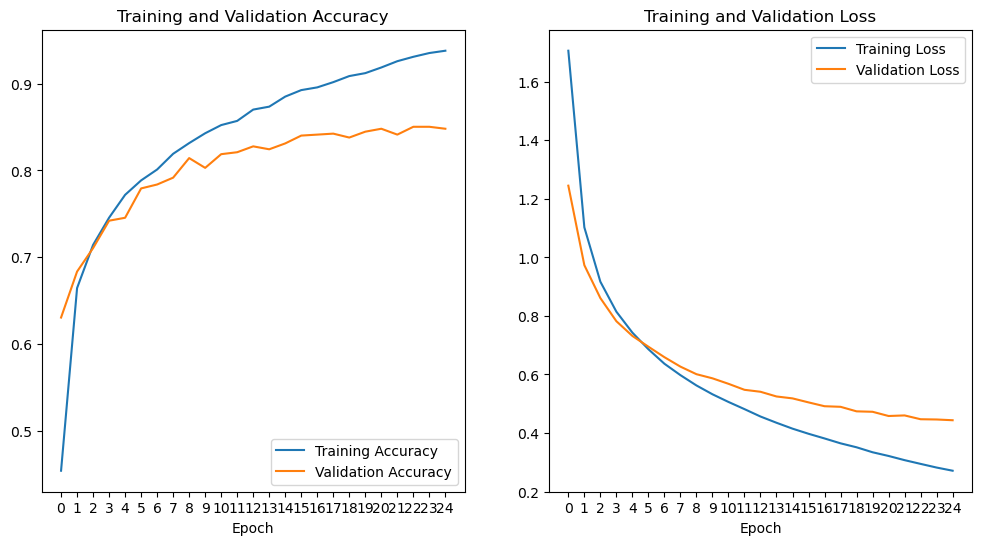

In [47]:
# Plot training and validation accuracy and loss
acc = mobile_net_history.history['accuracy']
val_acc = mobile_net_history.history['val_accuracy']
loss = mobile_net_history.history['loss']
val_loss = mobile_net_history.history['val_loss']

epochs_range = range(len(mobile_net_history.history['accuracy'])) 
plt.figure(figsize=(12, 6))

# Subplot for accuracy
plt.subplot(1, 2, 1)  
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')
plt.xticks(epochs_range)
plt.xlabel('Epoch')

# Subplot for loss
plt.subplot(1, 2, 2) 
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')
plt.xticks(epochs_range)
plt.xlabel('Epoch');

The above plot represents the training / validation history for our MobileNet model. When training this model we use early stopping with a patience of 2, however the model trains for the full 25 epochs allocated. This model has less overfitting than the baseline model but more overfitting than the tuned CNN model. We chose not to run this model for additional epochs to avoid further overfitting.

In [48]:
# Get accuracy for each class label
label_accuracies_mobile = {}

for features, label in test_dataset:
    predictions = tuned_model.predict(features, verbose=0)
    predicted_label = tf.argmax(predictions, axis=1).numpy()
    true_label = np.argmax(label, axis=1)
    true_label_names = label_encoder.inverse_transform(true_label)
    
    for i in range(len(true_label)):
        if true_label_names[i] not in label_accuracies_mobile:
            label_accuracies_mobile[true_label_names[i]] = {"count": 0, "accuracy": 0.0}
        label_accuracies_mobile[true_label_names[i]]["count"] += 1
        label_accuracies_mobile[true_label_names[i]]["accuracy"] += int(true_label[i] == predicted_label[i])

for label, values in label_accuracies_mobile.items():
    values["accuracy"] /= values["count"]
    print(f"{label} Accuracy:{values['accuracy']:.2f} (count = {values['count']})")

Happy Accuracy:0.86 (count = 88)
Resting Accuracy:0.92 (count = 90)
Paining Accuracy:0.72 (count = 83)
Angry Accuracy:0.92 (count = 91)
Warning Accuracy:0.74 (count = 91)
HuntingMind Accuracy:0.93 (count = 70)
Defence Accuracy:0.93 (count = 96)
Fighting Accuracy:0.92 (count = 108)
Mating Accuracy:0.74 (count = 82)
MotherCall Accuracy:0.94 (count = 90)


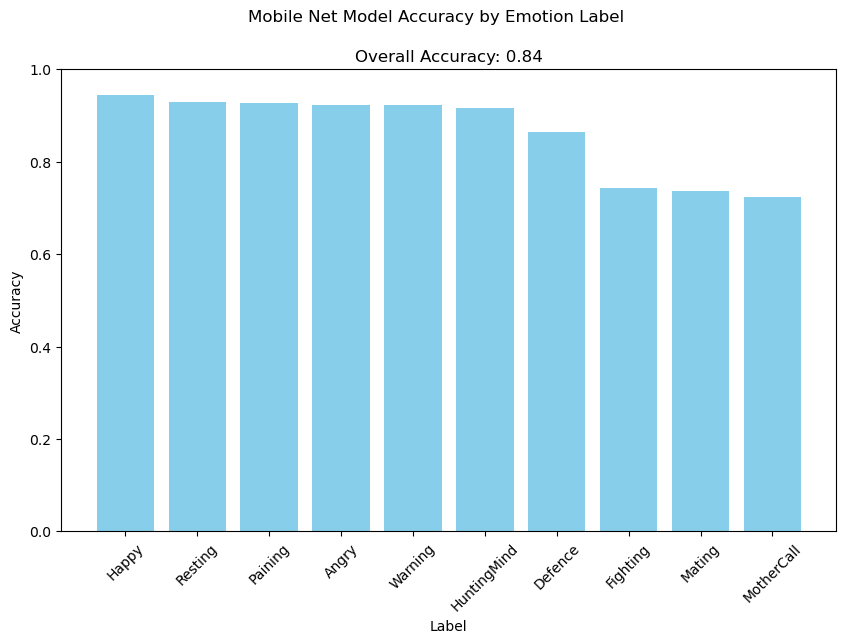

In [49]:
# Display accuracy for each class label
labels = [label for label in label_accuracies_mobile]
accuracies = [values['accuracy'] for values in label_accuracies_mobile.values()]
accuracies_sorted = sorted(accuracies, reverse=True)

plt.figure(figsize=(10, 6))
plt.bar(labels, accuracies_sorted, color='skyblue')
plt.xlabel('Label')
plt.ylabel('Accuracy')
plt.suptitle('Mobile Net Model Accuracy by Emotion Label')
plt.title(f"Overall Accuracy: {test_accuracy:.2f}")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()

Happy has the highest accuracy and MotherCall the lowest, which follows the same patterns as observed for the baseline and tuned CNN models.

28/28 [==============================] - 3s 86ms/step


Text(0.5, 1.0, 'Confusion Matrix for MobileNet Model')

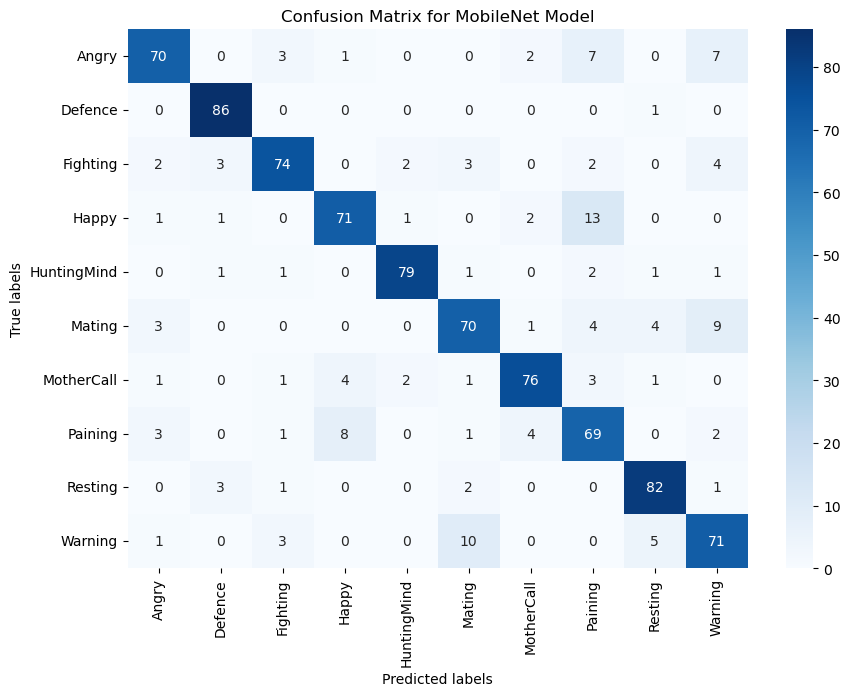

In [50]:
# Create confusion matrix 
predictions_probs = mobile_net_model.predict(test_generator)
predictions = np.argmax(predictions_probs, axis=1)

true_labels = test_generator.classes

if test_generator.shuffle:
    print("Warning: The generator is shuffling the data, true labels might not correspond to predictions.")

cm = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for MobileNet Model')

The above plot is a confusion matrix that allows us to better understand the types of errors that our MobileNet model is making. The darker colors along the diagonals represent that most of the time our model is making accurate predictions. The most commonly confused labels for this model are: happy / paining and warning / mating. 

## Analyze Transfer Learning Model

- The model’s validation loss after 24 epochs was 0.446 and the model’s validation accuracy was 0.850. The test accuracy was 0.841. The validation and test accuracy are somehwat lower than the training accuracy (0.85 and 0.841 compared to 0.935), suggesting that there is some overfitting. 
- The model was able to achieve 85% validation accuracy and 84.1% test accuracy, which is higher than the baseline model but lower than the tuned model. Since MobileNet is trained on a massive dataset and is able to achieve accuracies much higher than we ones we did on other datasets, this suggests that other models that are trained on audio data might be better for transfer learning. MobileNet was trained on ImageNet, which consists of 14 million RGB images, and not on audio data.

# Model Performance <a name="performance"></a>

Overall, the model that performed the best was the tuned model. It achieved a higher validation and test accuracy than the other two models. As can be seen from the feature maps of the baseline and tuned model, the deeper layers of the tuned model were able to extract information from the spectrograms, suggesting that the deeper layers helped with learning. 

The baseline model overfitted the most, but all three models showed some overfitting. As mentioned previously, data augmentation was not able to prevent this, but rather decreased both the validation and test accuracy. 

The tuned and baseline model were very fast to train, while MobileNet took several minutes. The tuned model also had the lowest number of total parameters, making it the least computationally expensive. MobileNet had the lowest number of trainable parameters because every layer except the top layer of MobileNet were frozen.

All models had the highest accuracy for the emotion "Happy", and the lowest accuracy for "MotherCall". 
The tuned and transfer learning model seem to confuse "Happy" and "Paining", as well as "Mating" and "Warning", while the baseline model mostly misclassified "HuntingMind" with "Fighting". 

When considering training time, model complexity, test accuracy and degree of overfitting, the best overall model was the tuned model.

# Predicting on Real Data <a name="real"></a>

In [51]:
# Load in data from Soline's cat named Blu
blu_audio, blu_sr = librosa.load("blu.mp3", sr=None, mono=True)

audio_data, sr = librosa.load(file_path)

desired_length = int(5 * sr)  
audio_padded = librosa.util.fix_length(audio_data, size=desired_length)

blu_mel_spec = librosa.feature.melspectrogram(y=audio_padded, sr=blu_sr)
blu_log_mel_spec = librosa.power_to_db(blu_mel_spec, ref=np.max)
blu_normalized_log_mel_spec = (blu_log_mel_spec - np.min(blu_log_mel_spec)) / (np.max(blu_log_mel_spec) - np.min(blu_log_mel_spec))

blu_emotion  = np.array([0,0,0,1,0,0,0,0,0,0]) # We think Blu was happy when his meow was recorded

# Turn Blu data into a tensorflow dataset
blu_data = tf.data.Dataset.from_tensor_slices(([blu_normalized_log_mel_spec], [blu_emotion]))
blu_data = blu_data.batch(1).prefetch(tf.data.AUTOTUNE)

### Baseline CNN Model

In [52]:
baseline_blu_preds = baseline_model.predict(blu_data)
baseline_blu_pred = np.argmax(baseline_blu_preds, axis=1)

1/1 [==============================] - 0s 90ms/step


In [53]:
baseline_predicted_label = label_encoder.inverse_transform(baseline_blu_pred)
print(f"The predicted emotion is: {baseline_predicted_label[0]}")

The predicted emotion is: MotherCall


### Tuned CNN Model

In [54]:
tuned_blu_preds = tuned_model.predict(blu_data)
tuned_blu_pred = np.argmax(tuned_blu_preds, axis=1)

1/1 [==============================] - 0s 88ms/step


In [55]:
tuned_predicted_label = label_encoder.inverse_transform(tuned_blu_pred)
print(f"The predicted emotion is: {tuned_predicted_label[0]}")

The predicted emotion is: MotherCall


### MobileNet

1/1 [==============================] - 2s 2s/step
The predicted emotion is: MotherCall


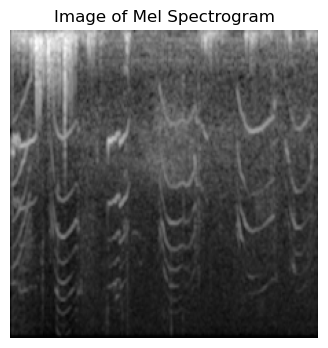

In [56]:
# Resize image to predict on MobileNet
image_format = (normalized_log_mel_spec * 255).astype(np.uint8)

image = Image.fromarray(image_format)

resized_image = image.resize((224, 224), Image.BICUBIC)

rgb_image = Image.merge("RGB", [resized_image, resized_image, resized_image])

image_array = np.array(rgb_image)

image_array = preprocess_input(image_array)
image_array = np.expand_dims(image_array, axis=0)

predictions = mobile_net_model.predict(image_array)
predicted_class_index = np.argmax(predictions)
predicted_class = emotions_list_mobile[predicted_class_index]
print(f"The predicted emotion is: {predicted_class}")

# Show the mel spectrogram of Blu's audio
plt.figure(figsize=(6, 4))
plt.imshow(rgb_image)
plt.title("Image of Mel Spectrogram")
plt.axis('off');

All three models are predicting "MotherCall" for our own cat audio file. Given that they all predicted the same emotion, this means we have agreement between the models and increase our confidence that this is the true label of the audio.

# Future Work/Scope of Improvement <a name="future"></a>

- To improve upon our project, we could try to find a HuggingFace model that has been trained on spectrograms for better predictions. MobileNet is trained on ImageNet which does not contain spectrograms, but we wanted to experiment with a popular model that had been introduced to us in class. 
- Throughout our project work, we discovered that the provided data was flawed. After visualizing some of the spectrograms, we realized that at least two audio files had the same audio but with two different emotion labels. Additionally, after listening to many of the audio files, we found that many were noisy, had random background noise or contained several cats meowing at the same time. Therefore, another improvement would be to scrape more cat meow data that is clearer and less noisy.
- For future work, we can apply our model to new cats. However, one limitation of the model is that we don't know the true label which makes it difficult to verify whether the model outputs are correct. This is also a more general limitation of our model.